## 1.0 Time Series Forecasting using LSTM

Time Series Forecasting on the [Shampoo Sale Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv). The dataset contains information of monthy shampoo sales for 36 consecutive months, i.e., time series. We train on the first 24 months using LSTM. We then evaluate the model for shampoo sales forecasting on the last 12 test months of the dataset.


## 2.0 Load Dataset

In [1]:
#imports
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [2]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('dataset/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


In [3]:
%matplotlib inline

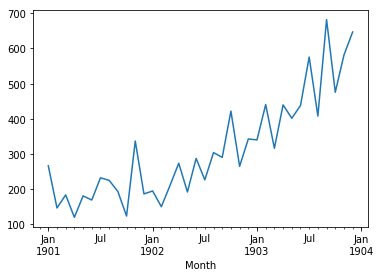

In [4]:
series.plot()
pyplot.show()

## 3.0 Train-Test Split

In [5]:
X = series.values
X

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [6]:
train, test = X[0:-12], X[-12:]

In [7]:
train

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3])

In [8]:
test

array([339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6, 682. ,
       475.3, 581.3, 646.9])

## 4.0 Simple Persistence Model Forecast

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [10]:
history = [x for x in train]

In [11]:
predictions = list()
for i in range(len(test)):
    #trivial: simply use the value of (t-1) to predict t
    predictions.append(history[-1])
    #add the last seen data to the history
    history.append(test[i])

In [12]:
predictions

[342.3,
 339.7,
 440.4,
 315.9,
 439.3,
 401.3,
 437.4,
 575.5,
 407.6,
 682.0,
 475.3,
 581.3]

In [13]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 136.761


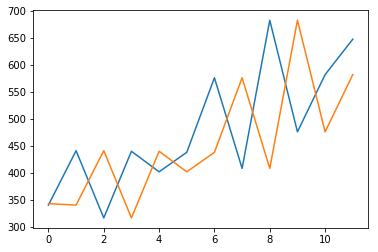

In [14]:
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

## 5.0 Forecasting using LSTM

#### 5.1 Time Series to Supervised Transformation

In [15]:
from pandas import DataFrame, concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    
    shiftedColumn = df.shift(lag)
    
    df = concat([shiftedColumn, df], axis=1)
    
    df.fillna(0, inplace=True)
    return df

In [16]:
supervised = timeseries_to_supervised(series.values, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


#### 5.2 Transform to Stationary

The simple difference method can be used for making the data stationary. The details of the method is [here](https://machinelearningmastery.com/difference-time-series-dataset-python/).

In [17]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

The method of `inverse difference` of the above difference while forecasting

In [18]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

#### 5.3 Scale the features to a Range

Using the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from Scikit Learn for scaling the features in the pre-processing step. 

In [19]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

The inverse scale of the above using the `MinMaxScaler` preprocessing class from Scikit Learn.

In [20]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [21]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

#### 5.4 Design and Fit the LSTM model

In [22]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print(X.shape)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [23]:
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

(23, 1, 1)


#### 5.5 Predict using the Trained Model

In [24]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    #print(len(X))
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    #print("yhat:", yhat)
    return yhat[0,0]

In [25]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.8776159 ],
       [-0.12440494],
       [-0.43893418],
       [ 0.03688592],
       [-0.33426023],
       [-0.05332309],
       [-0.2698441 ],
       [-0.0402773 ],
       [ 0.07713217],
       [ 0.38854575],
       [-0.94622517],
       [ 0.21555746],
       [ 0.06575519],
       [ 0.47183663],
       [ 0.00316364],
       [-0.30767596],
       [ 0.40587598],
       [-0.49939686],
       [ 0.22910833],
       [-0.35591745],
       [ 0.13022232],
       [-0.9131057 ],
       [ 0.23612952]], dtype=float32)

#### 5.6 Evaluate the Model on Test Data

In [26]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    #print(X)
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=261.937558, Expected=339.700000
Month=2, Predicted=354.600381, Expected=440.400000
Month=3, Predicted=290.623092, Expected=315.900000
Month=4, Predicted=363.440138, Expected=439.300000
Month=5, Predicted=256.889428, Expected=401.300000
Month=6, Predicted=373.959791, Expected=437.400000
Month=7, Predicted=428.521471, Expected=575.500000
Month=8, Predicted=385.708954, Expected=407.600000
Month=9, Predicted=433.927343, Expected=682.000000
Month=10, Predicted=465.641417, Expected=475.300000
Month=11, Predicted=461.304322, Expected=581.300000
Month=12, Predicted=366.434826, Expected=646.900000
